In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [12]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [27]:
# Modify default parameters
# -------------------------
run = 'stommel_arons'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

fac = 0.5
nx = int(250*fac)
ny = int(500*fac)
nt = 1000000
nt = nt//20

picture_frequency = 0
output_frequency = 500
diagnostic_frequency = output_frequency
diagnostic_frequency = 50

dx = 10e3/fac
dy = dx
y0 = -ny*dy/2.

grav = 0.02
rho = np.array([1000.])
#rho = np.array([1., 2., 3.])
nz = rho.size

H0 = 400.
cph = np.sqrt(grav*H0)
dist = dt*nt * cph
#dt  = 0.1*dx/np.sqrt(grav*H0)
#dt = 225./fac # for fac = 0.25
dt = 600.*fac
#dt = 1800.

nspx = 1
nspy = 1
epsab = 0.01

kh = 1e4*fac**2
Ah = kh
drag_coeff_linear = 2e-6
lam_ho = 1e-9

#lat_0 = 30.
#omega = 2*np.pi/(24.*3600.)     # Earth's angular frequency [s**-1]
#R = 6.371e6                     # Earth's radius [m]
#f0 = 2*omega*np.sin(lat_0*np.pi/180.)
#beta = 2*omega/R*np.cos(lat_0*np.pi/180.)
f0 = 0.
beta = 2.3e-11

print(f'Munk layer:    {(Ah/beta)**(1./3.)/1e3}km')
print(f'Stommel layer: {drag_coeff_linear/beta/1e3}km')
if dx>2.*drag_coeff_linear/beta:
    print(f'Resolution too small to resolve Stommel layer.')
    sys.exit()

do_momentum_advection = False
do_momentum_diffusion = True
do_momentum_drag = True
do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_momentum_windstress = False
do_height_diffusion = False
do_height_advection = True
do_height_stommel_arons = True

Munk layer:    47.72406086195675km
Stommel layer: 86.95652173913044km


In [28]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [29]:
Yt.shape

(250, 125)

In [30]:
yt[0], yt[-1], yt[-1]-yt[0], Ly

(-2490000.0, 2490000.0, 4980000.0, 4980000.0)

In [31]:
ft0[0,:,10].min(), ft0[0,:,10].max()

(-5.7270000000000006e-05, 5.7270000000000006e-05)

In [32]:
# Modify initial conditions
# -------------------------
#ho0 = 0.01*(Xt-Lx/2.)/Lx
#ho0 = H0+0.1*np.sin(Xt/(Lx+dx)*2*np.pi*2)
#ho0 = H0+0.1*np.exp(-((Xt-0.5*Lx)**2+(Yt-0.5*Ly)**2)/(1.e-3*(Lx**2+Ly**2)))
#ho0 = ho0[np.newaxis,:,:]
#H0 = 0.
#ho0 += H0

#uo0 = cph + 0.*Xu
#uo0 = uo0[np.newaxis,:,:]

maskt0[:,:,0] = 0.
maskt0[:,:,-1] = 0.
maskt0[:,0,:] = 0.
maskt0[:,-1,:] = 0.

eta0[0,:,:] = 0.
#eta0[1,:,:] = -10.
#eta0[2,:,:] = -40.
#eta0[3,:,:] = -100.
eta0[nz,:,:] = -H0
ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

#ho0 *= maskt[:,nspy:-nspy,nspx:-nspy]
ho0 *= maskt0

#taux0 = -1e-4*np.cos(2.*np.pi*Yt/Ly * 0.5)
#taux0 = -1e-4*np.cos(2.*np.pi*Yt/Ly)

ny_dw = 32
dw_source0 = np.zeros((nz,ny,nx))
dw_source0[:,-5:,:] = 5e6/((nx-2)*dx*ny_dw*dy)
dw_source0 *= maskt0

ix = np.array([nx//2])
iy = np.array([ny//2])

## Run the model

In [33]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

ll =  49950/ 50000, Total run time: 10.14min, done at 2022-08-25 19:21:50.058144, ho.sum = 1.2e+07, ke.sum = 5.1e-02, cflu = 1.3e-04, cflv = 4.8e-05
--- All done! ---
Total run time: 10.14min, done at 2022-08-25 19:21:50.108098
------


## Post-process the result

In [34]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [35]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    ds = xr.open_mfdataset(f'{path_data}/{file_prfx}_????.nc', **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

ValueError: Indexes along dimension 'xt' don't have the same length. Cannot use join='override'.

## Plot overview

In [107]:
nps = ds.time.size
nps

100

In [108]:
ds.yt.max(), Ly

(<xarray.DataArray 'yt' ()>
 array(2450000.),
 4900000.0)

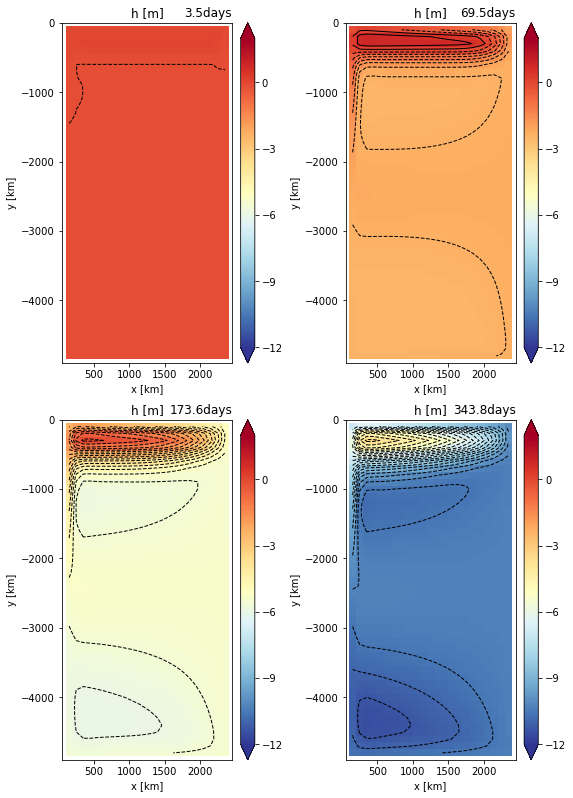

In [112]:
# prepare the animation
iz = 0
steps = [1, 20, 50, nps-1]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=2., fig_size_fac=3, axlab_kw=None, 
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

conts = np.linspace(-12,6,51)

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds['ho'][ll,iz,:,:].compute()
    # clim = 5e-2
    # clim = 'auto'
    clim = [-12, 2]
    hm = shade(ds.xt/1e3, (ds.yt-Ly/2.)/1e3, data-H0, conts=conts, ax=ax, cax=cax, clim=clim)
    ax.set_title('h [m]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

## Make an animation

In [114]:
fpath

'/Users/nbruegge/work/movies/shallow_py/stommel_arons//test_combined.nc'

In [113]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/test_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

OSError: no files to open

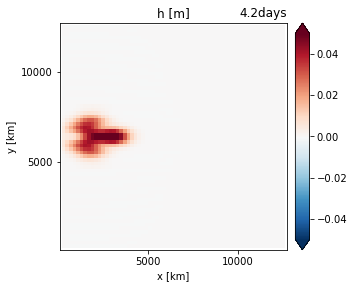

In [30]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=1., fig_size_fac=2, axlab_kw=None)
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['ho'][ll,iz,:,:].compute()
clim = 5e-2
hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
ax.set_title('h [m]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

for ax in hca:
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')

In [31]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    hm[0].set_array(data.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [32]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

CPU times: user 10.9 s, sys: 1.11 s, total: 12 s
Wall time: 12 s


## Showing the animation

In [33]:
%%time
HTML(ani.to_jshtml())

CPU times: user 12.6 s, sys: 1.08 s, total: 13.7 s
Wall time: 13.8 s
